<a href="https://colab.research.google.com/github/GA239/DS_course/blob/master/HW7/tsk1/TF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow-gpu

In [2]:
# import tensorflow as tf
# import os
# tf.__version__
import matplotlib.pylab as plt
import os

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
tf.__version__

'2.2.0'

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# read dataset
DRIVE = '/content/drive/My Drive'
titanic_path = os.path.join(DRIVE, 'titanic3.xls')


In [7]:
import pandas as pd
xl = pd.ExcelFile(titanic_path)
df = xl.parse(xl.sheet_names[0])
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [8]:
df = pd.concat([df, pd.get_dummies(df.embarked, prefix='embarked')], axis=1)
df = pd.concat([df, pd.get_dummies(df.survived, prefix='survived')], axis=1)

In [9]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked_C', 'embarked_S', 'embarked_Q']
df.shape

(1309, 19)

In [10]:
df = df.dropna(subset=features)
df.shape

(1046, 19)

In [11]:
X = df[features]
Y = df[['survived_0',	'survived_1']]

In [12]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [13]:
Xtrain, Xtest, Ytrain, Ytest, =  train_test_split(X, Y)
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((784, 8), (784, 2), (262, 8), (262, 2))

In [14]:
Xtrain

,pclass,sex,age,sibsp,parch,embarked_C,embarked_S,embarked_Q
857,3,male,27.0,0,0,0,1,0
720,3,male,24.0,0,0,0,0,1
668,3,male,22.0,0,0,0,1,0
215,1,male,58.0,0,2,1,0,0
799,3,male,18.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
207,1,female,33.0,1,0,0,0,1
559,2,female,20.0,0,0,0,1,0
561,2,male,59.0,0,0,0,1,0
520,2,male,20.0,0,0,1,0,0


In [15]:
lencoder = LabelEncoder().fit(Xtrain.sex)
Xtrain['sex'] = lencoder.transform(Xtrain.sex)
Xtest['sex'] = lencoder.transform(Xtest.sex)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
Xtrain.head(4)

,pclass,sex,age,sibsp,parch,embarked_C,embarked_S,embarked_Q
857,3,1,27.0,0,0,0,1,0
720,3,1,24.0,0,0,0,0,1
668,3,1,22.0,0,0,0,1,0
215,1,1,58.0,0,2,1,0,0


In [59]:
tf.reset_default_graph()

In [60]:
N_EPOCHS = 10000
display_step = 100 

# Step 1: init dataset

In [61]:
# Step 2: create placeholders for X and Y
X = tf.placeholder(tf.float32,  [None, Xtrain.shape[1]], name='X')
Y = tf.placeholder(tf.float32, [None, Ytrain.shape[1]], name='Y')

In [62]:
# Step 3: create weight and bias, initialized to 0
w = tf.get_variable('weights', initializer=tf.zeros([Xtrain.shape[1], Ytrain.shape[1]]))
b = tf.get_variable('bias', initializer=tf.zeros([Ytrain.shape[1]]))

In [63]:
# Step 4: build model to predict Y
logits = tf.matmul(X, w) + b

In [64]:
# Step 5: use cross_entropy as the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits, Y), name='loss')

In [65]:
# Step 6: using gradient descent with learning rate of 0.001 to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [66]:
# Step 7: calculate accuracy with test set
preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [71]:
with tf.Session() as sess:
  # Step 7: initialize the necessary variables, in this case, w and b
  sess.run(tf.global_variables_initializer()) 

  # print("веса:{}".format(sess.run(w))) 
  # print("y_:{}".format(sess.run(correct_prediction, feed_dict={X: Xtest, Y: Ytest}))) 
  # print("Точность: %s" % sess.run(accuracy, feed_dict={X: Xtest, Y: Ytest})) 
  # print("Точность: %s" % sess.run(accuracy, feed_dict={X: Xtrain, Y: Ytrain})) 

  # Step 8: train the model
  for i in range(N_EPOCHS): 
    Xbatch = Xtrain.sample(100)
    Ybatch = Ytrain[Ytrain.index.isin(Xbatch.index)]
    # Session execute optimizer and fetch values of loss
    _, l, a_val = sess.run([optimizer, loss, accuracy], feed_dict={X: Xbatch, Y:Ybatch}) 
    if (i+1) % display_step == 0: 
      print(f'Эпоха {i+1}:  {l} {a_val}')
      
  # # print("веса:{}".format(sess.run(w))) 
  # print("y_:{}".format(sess.run(correct_prediction, feed_dict={X: Xtest, Y: Ytest}))) 
  print("Точность: %s" % sess.run(accuracy, feed_dict={X: Xtest, Y: Ytest})) 
  print("Точность: %s" % sess.run(accuracy, feed_dict={X: Xtrain, Y: Ytrain})) 



Эпоха 100:  -5.564963340759277 0.5600000023841858
Эпоха 200:  -11.605781555175781 0.550000011920929
Эпоха 300:  -18.451749801635742 0.6100000143051147
Эпоха 400:  -23.35013198852539 0.5799999833106995
Эпоха 500:  -28.13202476501465 0.5699999928474426
Эпоха 600:  -36.17837905883789 0.5799999833106995
Эпоха 700:  -40.490867614746094 0.6000000238418579
Эпоха 800:  -45.38417053222656 0.5699999928474426
Эпоха 900:  -49.966041564941406 0.5899999737739563
Эпоха 1000:  -54.094573974609375 0.6399999856948853
Эпоха 1100:  -66.46183776855469 0.5799999833106995
Эпоха 1200:  -70.34831237792969 0.5699999928474426
Эпоха 1300:  -75.07780456542969 0.5699999928474426
Эпоха 1400:  -83.80850219726562 0.6100000143051147
Эпоха 1500:  -86.00579071044922 0.6399999856948853
Эпоха 1600:  -97.61573028564453 0.6200000047683716
Эпоха 1700:  -98.70995330810547 0.5600000023841858
Эпоха 1800:  -104.19453430175781 0.5799999833106995
Эпоха 1900:  -105.0035171508789 0.5899999737739563
Эпоха 2000:  -115.6541976928711 0.5

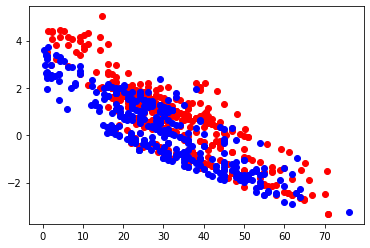

In [68]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def plot_titanic(x, y, target):
  pca = TruncatedSVD(n_components=2)
  X_r = pca.fit(x).transform(x)
  a = pd.DataFrame(X_r, index = x.index)
  a_1 = a[a.index.isin(y[y[f'{target}_{1}'] == 1].index)]
  a_0 = a[a.index.isin(y[y[f'{target}_{0}'] == 1].index)]

  plt.scatter(a_0[0], a_0[1], color='red')
  plt.scatter(a_1[0], a_1[1], color='blue')
plot_titanic(Xtrain, Ytrain, 'survived')

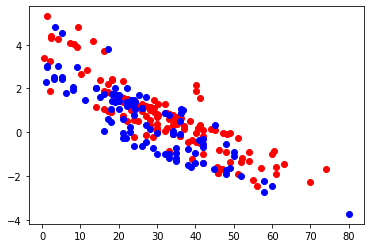

In [69]:
plot_titanic(Xtest, Ytest, 'survived')